# Кластеризация и снижение размерности

In [1]:
# !pip install scikit-learn pandas -q
!pip install hdbscan umap-learn -q

In [19]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import homogeneity_completeness_v_measure

from sklearn.cluster import (
    KMeans,
    DBSCAN,
    AgglomerativeClustering
)
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import (
    TruncatedSVD,
    PCA
)
from sklearn.manifold import TSNE
import umap

from matplotlib import pyplot as plt

from scipy.stats import entropy
import numpy as np

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[Датасет эмоций](https://www.kaggle.com/datasets/nelgiriyewithana/emotions?resource=download)

In [5]:
!curl -L -o emotions.zip https://www.kaggle.com/api/v1/datasets/download/nelgiriyewithana/emotions
!unzip emotions.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15.6M  100 15.6M    0     0  20.7M      0 --:--:-- --:--:-- --:--:-- 83.2M
Archive:  emotions.zip
  inflating: text.csv                


## Кластеризация

### Теория

**Кластеризация** $-$ одна из классических задач обучения без учителя, в рамках которой требуется разбить множество объектов на группы по "похожести" так, чтобы объекты внутри группы были как можно более похожи, а группы между собой при этом максимально отличались.

Кластеризацяи часто используется как способо анализа данных: в задаче анализа социальных сетей, тематического моделирования или просто как первый этап подготовки датасета для новой задачи, когда есть большой объем данных, но нет четкого понимания структуры классов. Однако, кластеризация также может быть и частью алгоритма решения более сложной задачи, чаще всего в свере построения рекомендательных систем.

Группы объектов в данном случае называются **кластерами**. Часто для кластера вводя такое понятие, как **центроид** - определеная точка центра кластера (часто точка внутри кластера, равноудаленная от всех объектов кластера).

***
Алгоритмы кластеризации можно условно разделить на несколько групп:
1. Неиерархические четкие алгоритмы $-$ выделяют $n$ кластреров так, что все кластеры равнозначны (нет иерархии) и при этом любой объект может принадлежать только к одному кластеру.
<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/partitioning-clustering.webp?raw=true" width="400"/>
</div>
2. Иерархические четкие алгоритмы $-$ объекты все еще не могут принадлежать более, чем к одному кластеру, однако алгоритм выстраивает иерархию вложенности для кластеров
<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/hclust-example.png?raw=true" width="400"/>
</div>
3. Неиерархические нечеткие алгоритмы $-$ выделяют $n$ равнозначных кластреров, но для каждого объекта определяется не один конкретный кластер, а распределние вероятностей принадлежать к каждому кластеру
<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/normalcomparison.png?raw=true" width="400"/>
</div>
4. Иерархические нечеткие алгоритмы $-$ строим иерархию для распределений вероятностей. Очень редкая штука (может, так вообще не делают, но я верю, что так можно).

***
Еще несмотря на то, что кластеризация $-$ это обучение без учителя, существуют метрики для оценки кластеризации. Их условно можно разделить на две группы:
1. Метрики, которые в действительности требуют правильных лейблов. Их обычно используют, чтобы настроить алгоритм кластеризации, который потом будет работать автономно на похожих данных, или для проверки нового алгоритма.
    - Однородность (*homogenity*) $-$ уменьшается, если в кластере оказываются объекты разных классов (аналог `precision` для классификации)
<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/homo.png?raw=true" width="400"/>
</div>
    - Полнота (*completeness*) $-$ уменьшается, если объекты одного класса оказываются в разных кластерах (аналог recall для классификации)
<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/compl.png?raw=true" width="400"/>
</div>
    - *V-measure* $-$ связывает предыдущие два (аналог *F-score* для классификации)
$$v = (1 + \beta) * \frac{homogeneity * completeness}{\beta * homogeneity + completeness},$$ где $\beta$ отражает соотношение весов, приписываемых однородности (< 1) и полноте (> 1): больше 1, при расчете учитывается полнота. Если коэффициент бета меньше 1, то при расчете учитывается однородность.

    - Rag Bag
<div>
<img src="https://github.com/hse-ling-python/seminars/blob/master/ml/static/ragbag.png?raw=true" width="400"/>
</div>
2. Метрики, которые используют только свойства кластеров и объектов внутри них:
    - Энтропия $-$ "оценка беспорядочности". Максимальная для равномерного распределения, так как в нем нет никакой определенности

    $$H = -\sum_{i = 0}^n (x_{i} \cdot \log x_{i})$$

    - Разные способы оценить "плотность" кластера: среднее отклонение от центроида, средня попарная близость между элементами и т.д.
    - Оценки для "разнообразия" кластеров: расстояние между центроидами, расстояние между ближайшими элементами на границе и т.д.

### Практика

**Какие есть алгоритмы в питоне?**

Вообще, множество. Большая часть из них живет в библиотеке sklearn, но есть отедльные, например, HDBSCAN.

Мы сегодня посмотрим на K-means, DBSCAN, и AgglomerativeClustering

In [7]:
labels = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}
labels_list = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

df = pd.read_csv('text.csv').drop(columns=['Unnamed: 0']).sample(10000)
df = df.reset_index(drop=True)

df.head()

,text,label
0,i walk around the world i live in and i don t ...,0
1,i feel as if vital organs have been ripped fro...,1
2,i feel like making my child believe a strange ...,4
3,i was feeling very excited though i was very t...,1
4,i had the folks use stem sentences to trigger ...,0


In [8]:
tfidf = TfidfVectorizer(stop_words=stops).fit(df.text)
vecs = tfidf.transform(df.text)
vecs.shape

(10000, 11685)

#### K-Means
Алгоритм:
1. Выбираем кол-во кластеров $k$ (гиперпараметр, нужно назначить руками)
2. Выбираем $k$ случайных объектов. Они будут центроидами будущих кластеров
3. Перебираем все объекты в данных, относим их к ближайшим центроидам
4. Для каждого получившегося кластера считаем среднее значение. Эти значения будут новыми кластерами
5. Повторяем шаги 3-4, пока центроиды не перестанут двигаться

In [9]:
kmeans = KMeans(n_clusters=len(labels), random_state=0, n_init="auto")
kmeans.fit(vecs)

preds = kmeans.labels_
# homogeneity, completeness, v_measure
homogeneity_completeness_v_measure(df.label, preds)

(0.002412072016151581, 0.0026087206319365085, 0.002506545270953368)

In [10]:
kmeans = KMeans(n_clusters=100, random_state=0, n_init="auto")
kmeans.fit(vecs)

preds = kmeans.labels_
# homogeneity, completeness, v_measure
homogeneity_completeness_v_measure(df.label, preds)

(0.12467852674902787, 0.04812957573795499, 0.06944957452462046)

#### DBSCAN
Интуиция: если между точками можно проложить "плотную" дорожку, то они относятся к одному кластеру

Алгоритм (очень неформально):
1. Берем случайную точку. Если рядом меньше нужного кол-ва точек, то считаем, что эта точка может быть шумом и идем к следующей. В итоге нам нужна точка, у которой достаточное кол-во соседей
2. Для такой точки создаем группу, в которой она пока будет одна
3. Обходим всех соседей точки. Если точка есть в списке возможного шума, то считаем, что это край группы. Если рядом есть другие "популярные" точки, то считаем их частью группы и перебираем и их соседей тоже
4. Алгоритм заканчивается, когда мы тем или иным способом посмотрели на все точки
5. В списке шума остался шум, остальное разделилось на кластеры

In [13]:
# eps - макс. расстояние между двумя точками, при котором одна из них должна
# рассматриваться как находящаяся по соседству с другой.

dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan.fit(vecs)

preds_db = dbscan.labels_
# homogeneity, completeness, v_measure
homogeneity_completeness_v_measure(df.label, preds_db)

(0.02364446146456108, 0.1739002487386563, 0.04162883152627974)

#### AgglomerativeClustering
Интуиция: объединяем кластеры, пока можем это делать

Алгоритм:
1. Каждый объект представляет собой кластер
2. Считаем попарную близость для всех кластеров
3. Объединяем два с наибольшим значением
4. Повторяем 2-3, пока не достигнут критерий остановки (чаще всего кол-во кластеров)

In [14]:
# n_clusters - количество кластеров, которые нужно найти
# должно быть None, если значение distance_threshold не None

agl = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agl = agl.fit(vecs.toarray())

In [15]:
# отсюда: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

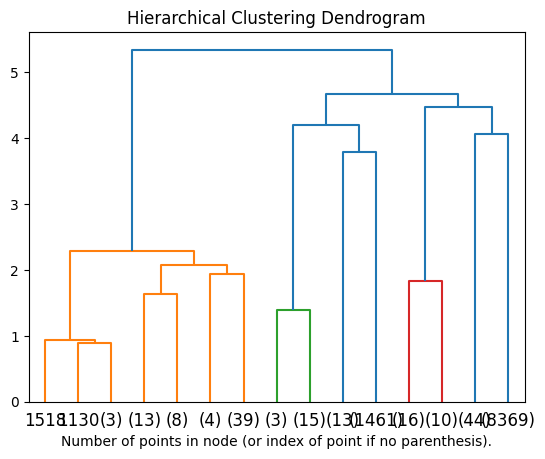

In [16]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(agl, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Снижение размерности

Здесь обсудим в общих чертах. Идея **снижения размерности** заключается в том, что иногда мы хотим перейти в пространство меньшей размерности (например, от 300 значений в эмбеддинге от word2vec к 2-м для визуализации) так, чтобы потерять как можно меньше информации об отношениях между объектами.

Такие алгоритмы могут быть построены двумя способами (возможно, есть еще, но эти основные):
1. Отбор признаков $-$ выбираем нужное кол-во признаков из имеющихся (часто используется в МЛ)
2. Проекция признаков $-$ преобразуем исходное кол-во характеристик в новое так, что новые характеристики представляют собой некоторую агрегацию старых

Популярные алгоритмы (см. например, [тут](https://www.kaggle.com/discussions/general/560484)):
- SVD (Singular Value Decomposition)
- UMAP (Uniform Manifold Approximation and Projection)
- TSNE (T-distributed Stochastic Neighbor Embedding)
- PCA (Principal Component Analysis)

In [17]:
cur = df[df.label.isin([0, 2])]
cur_vecs = vecs[cur.index, :]

(3700, 2)


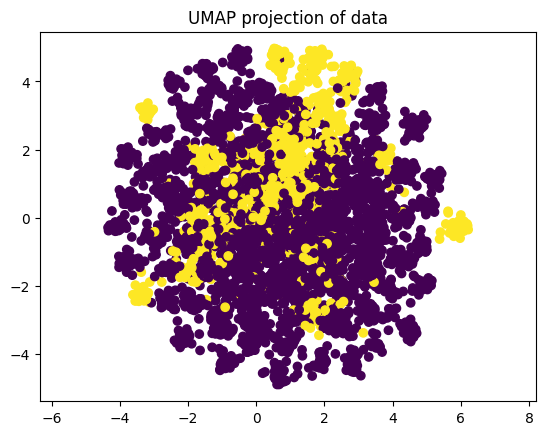

In [21]:
reducer = umap.UMAP(n_neighbors=20, min_dist=0.5, n_components=2)

embedding = reducer.fit_transform(cur_vecs)
print(embedding.shape)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=cur.label)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of data', fontsize=12);